# RegNet Classification

RegNet code

In [1]:
!pip install wandb


## Import

In [2]:
from __future__ import print_function

import glob
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
import wandb
from kaggle_secrets import UserSecretsClient

# Initialize W&B with Kaggle secrets
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_KEY")
wandb.login(key=secret_value_0)

# Initialize W&B run
run = wandb.init(project="ai-vs-human-generated-images", name="RegNet Classification", entity="DevGru")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: e20179 (DevGru). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Configuration and Reproducibility

In [4]:
batch_size = 16
epochs = 12
lr = 5e-5
gamma = 0.7
seed = 42

# Log hyperparameters
wandb.config = {
    "epochs": epochs,
    "batch_size": batch_size,
    "IMG_SIZE": 224,
    "optimizer": "adam",
    "loss_function": "cross_entropy",
}

def seed_everything(seed):
    """
    Sets the random seed for reproducibility in python, numpy, and torch.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used :", device)

Device used : cuda


## Data Preparation and Transformation

In [5]:
# Paths to the dataset
base_dir = '/kaggle/input/ai-vs-human-generated-dataset'
train_csv_path = os.path.join(base_dir, 'train.csv')
test_csv_path  = os.path.join(base_dir, 'test.csv')

# Reading the training CSV file
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

# Adding the full path to the file_name instead of just "trainORtest_data/xxx.jpg"
df_test['id'] = df_test['id'].apply(lambda x: os.path.join(base_dir, x))
df_train['file_name'] = df_train['file_name'].apply(lambda x: os.path.join(base_dir, x))

# Limit dataset size to 5000 while maintaining class balance
total_limit = 5000

df_train_limited, _ = train_test_split(
    df_train, 
    train_size=min(total_limit, len(df_train)), 
    stratify=df_train['label'], 
    random_state=42
)

# Extract paths and labels
all_image_paths = df_train_limited['file_name'].values
all_labels = df_train_limited['label'].values

# Splitting train/validation (95% / 5%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=0.05,        
    stratify=all_labels,
    random_state=42
)

print(f"Train Data: {len(train_paths)}")
print(f"Validation Data: {len(val_paths)}")

Train Data: 4750
Validation Data: 250


In [6]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

train_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

test_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

## Custom Dataset Implementation

In [ ]:
class ImageDataset(Dataset):

    def __init__(self, file_list, labels=None, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            label = self.labels[idx]
            return img, label
        else:
            return img

class TestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path) 


## DataLoaders

In [8]:
train_data = ImageDataset(train_paths, train_labels, transform=train_transforms)
val_data   = ImageDataset(val_paths,   val_labels,   transform=val_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(dataset=val_data,   batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train Dataset size: {len(train_data)}")
print(f"Validation Dataset size: {len(val_data)}")

Train Dataset size: 4750
Validation Dataset size: 250


## Model Initialization

In [9]:
# Load pre-trained Regnet
model_path = "/kaggle/input/regnety_32gf_binaryclassifier/pytorch/default/1/regnet_y_32gf_swag-04fdfa75.pth"  

model = models.regnet_y_32gf()
state_dict = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(state_dict)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

<ipython-input-9-35cece4391fb>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_availab

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(232, 232, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1):

## Training the Model

In [10]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1s = []

In [11]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = output.argmax(dim=1)
        acc = (preds == label).float().mean().item()
        epoch_accuracy += acc

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # -- Validation --
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_pred_classes = []
    val_labels_list = []

    with torch.no_grad():
        for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device)
            output = model(data)

            loss = criterion(output, label)
            val_loss += loss.item()

            preds = output.argmax(dim=1)
            acc = (preds == label).float().mean().item()
            val_acc += acc

            val_pred_classes.extend(preds.cpu().numpy())
            val_labels_list.extend(label.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    val_f1 = f1_score(val_labels_list, val_pred_classes)

    # Log metrics to W&B
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": epoch_loss,
        "train_accuracy": epoch_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "val_f1": val_f1
    })

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
    )

    scheduler.step()

Training Epoch 1:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/12] Train Loss: 0.1241 | Train Acc: 0.9476 | Val Loss: 0.0156 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 2:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2/12] Train Loss: 0.0404 | Train Acc: 0.9844 | Val Loss: 0.0034 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 3:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3/12] Train Loss: 0.0081 | Train Acc: 0.9979 | Val Loss: 0.0036 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 4:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4/12] Train Loss: 0.0170 | Train Acc: 0.9964 | Val Loss: 0.0061 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 5:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5/12] Train Loss: 0.0032 | Train Acc: 0.9994 | Val Loss: 0.0089 | Val Acc: 0.9922 | Val F1: 0.9921


Training Epoch 6:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6/12] Train Loss: 0.0017 | Train Acc: 0.9996 | Val Loss: 0.0100 | Val Acc: 0.9961 | Val F1: 0.9960


Training Epoch 7:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7/12] Train Loss: 0.0011 | Train Acc: 0.9998 | Val Loss: 0.0034 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 8:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8/12] Train Loss: 0.0011 | Train Acc: 0.9998 | Val Loss: 0.0030 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 9:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9/12] Train Loss: 0.0013 | Train Acc: 0.9998 | Val Loss: 0.0039 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 10:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10/12] Train Loss: 0.0012 | Train Acc: 0.9998 | Val Loss: 0.0046 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 11:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11/12] Train Loss: 0.0008 | Train Acc: 1.0000 | Val Loss: 0.0030 | Val Acc: 1.0000 | Val F1: 1.0000


Training Epoch 12:   0%|          | 0/297 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12/12] Train Loss: 0.0006 | Train Acc: 1.0000 | Val Loss: 0.0030 | Val Acc: 1.0000 | Val F1: 1.0000


## Save model

In [12]:
torch.save(model.state_dict(), "model_weights.pth")

torch.save(model, "model.pth")


# Log model as artifact
artifact = wandb.Artifact('trained_regnet_model', type='model')
artifact.add_file('model.pth')
wandb.log_artifact(artifact)
wandb.save("model.pth")

['/kaggle/working/wandb/run-20250306_075033-8sdsokze/files/model.pth']

In [13]:
wandb.finish()


epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_accuracy,▁▆██████████
train_loss,█▃▁▂▁▁▁▁▁▁▁▁
val_accuracy,████▁▅██████
val_f1,████▁▄██████
val_loss,█▁▁▃▄▅▁▁▂▂▁▁
epoch,12
train_accuracy,1
train_loss,0.00063
val_accuracy,1
val_f1,1


## Visualization of Loss and Accuracy

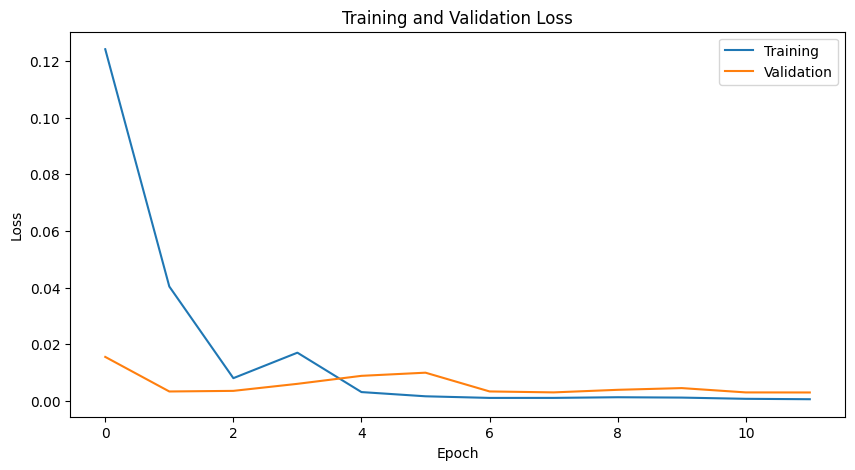

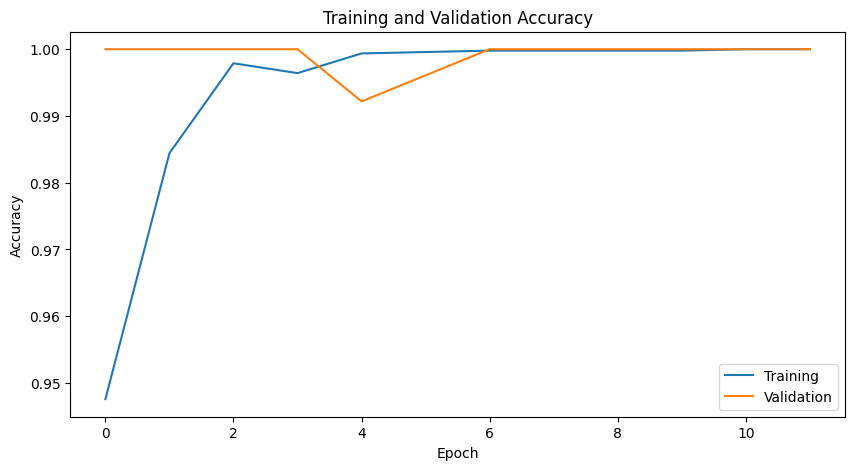

In [14]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Load model

In [15]:
#model.load_state_dict(torch.load("model_weights.pth"))
#model.to(device)

# OR, load the full model
#model = torch.load("model.pth")
#model.to(device)

## Inference on Test Data and Submission Generation

In [16]:
test_dataset = TestImageDataset(df_test['id'].values, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model.eval()
predictions = []
image_names = []

with torch.no_grad():
    for data, names in tqdm(test_loader, desc="Predicting"):
        data = data.to(device)
        outputs = model(data)
        
        preds = outputs.argmax(dim=1)  # shape [batch_size]
        
        predictions.extend(preds.cpu().numpy())
        image_names.extend([f"test_data_v2/{name}" for name in names])

submission_df = pd.DataFrame({
    'id': image_names,
    'label': predictions
})

Predicting:   0%|          | 0/347 [00:00<?, ?it/s]

In [17]:
submission_df.to_csv("submit.csv", index=False)
print("Submission file generated: submit.csv")

Submission file generated: submit.csv
